# Notebook to generate molecules from Pretrained Models

In [1]:
import sys
sys.path.append('../Optimizer/release')
sys.path.append('../Optimizer')
import pandas as pd
import pickle5 as pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdmolfiles
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import os
from joblib import Parallel, delayed
from rdkit.Chem import Crippen
from rdkit.Chem.QED import qed
from Predictors.SolvationPredictor import FreeSolvPredictor
from rdkit.Chem.rdMolDescriptors import CalcTPSA

Using backend: pytorch


In [2]:
use_cuda = torch.cuda.is_available()

In [3]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [4]:
gen_data_path = '../Optimizer/random.smi'

In [5]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [6]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Perform docking calculation to fetch binding affinity to receptor

In [7]:
def dock_and_get_score(smile: str, index: int, receptor: str) -> float:
    """
        smile: SMILES string of the molecule
        index: Index of the molecule
        Receptor: PDB ID of receptor
    """
    try:
        path = "~/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/"
#         path = "python2.5 ~/MGLTools-1.5.6/mgltools_x86_64Linux2_1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24"
        mol = Chem.MolFromSmiles(smile)
        AllChem.EmbedMolecule(mol)
        if not os.path.exists("molecules"):
            os.mkdir("molecules")
        if not os.path.exists("logs"):
            os.mkdir("logs")
        rdmolfiles.MolToPDBFile(mol, "molecules/" + str(index) + ".pdb")
    
        os.system(f"{path}/prepare_ligand4.py -l molecules/{str(index) + '.pdb'} -o molecules/{str(index) + '.pdbqt'}")
        os.system(f"{path}/prepare_receptor4.py -r ../Optimizer/{receptor}.pdb")    
        os.system(f"{path}/prepare_gpf4.py -i ../Optimizer/{receptor}_ref.gpf -l molecules/{str(index) + '.pdbqt'} -r {receptor}.pdbqt")
    
        os.system(f"autogrid4 -p {receptor}.gpf > /dev/null 2>&1")
        os.system(f"~/AutoDock-GPU/bin/autodock_gpu_64wi -ffile {receptor}.maps.fld -lfile molecules/{str(index) + '.pdbqt'} -resnam logs/{str(index)} -nrun 5 -devnum 1")
    
        cmd = f"cat logs/{str(index) + '.dlg'} | grep -i ranking | tr -s '\t' ' ' | cut -d ' ' -f 5 | head -n1"
        stream = os.popen(cmd)
        output = float(stream.read().strip())
        return output
    except Exception as e:
        print(f"Did Not Complete because of {e}")
        return 0

In [8]:
from tqdm.notebook import tqdm
class Predictor(object):
    def __init__(self):
        super(Predictor, self).__init__()
        
    def predict(self, smiles, receptor, use_tqdm=False):
        canonical_indices = []
        invalid_indices = []
        if use_tqdm:
            pbar = tqdm(range(len(smiles)))
        else:
            pbar = range(len(smiles))
        for i in pbar:
            sm = smiles[i]
            if use_tqdm:
                pbar.set_description("Calculating predictions...")
            try:
                sm = Chem.MolToSmiles(Chem.MolFromSmiles(sm))
                if len(sm) == 0:
                    invalid_indices.append(i)
                else:
                    canonical_indices.append(i)
            except:
                invalid_indices.append(i)
        canonical_smiles = [smiles[i] for i in canonical_indices]
        invalid_smiles = [smiles[i] for i in invalid_indices]
        if len(canonical_indices) == 0:
            return canonical_smiles, [], invalid_smiles
        prediction = [dock_and_get_score(smiles[index], index, receptor) for index in tqdm(canonical_indices)]
        return canonical_smiles, prediction, invalid_smiles

## Create KDEPlot of binding affinities of generated molecules

In [9]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted Docking Score', 
           title='Distribution of predicted Docking for generated molecules')
    plt.show()

In [10]:
def estimate_and_update(generator, predictor, n_to_generate, receptor):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])
    
    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, receptor)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Automatically loads the pretrained models given in the repository

In [11]:
def load_pretrained(
    reward, calculator, receptor, 
    LogP_target=None, QED_target=None, 
    hydration_target=None, TPSA_target=None, strategy=None):
    """
        reward: Exponential/Linear (All current models use exponential)
        calculator: docking/gin
        receptor: 4BTK/6LU7
        LogP_target: Optional
        QED_target: Optional
        hydration_target: Optional
        TPSA_target: Optional
        Strategy: None for Single Objective and sum/switch for Multiobjective
    """
    
    file_name = f'../models/{calculator}/model_{reward}_{calculator}_{receptor}'
    if LogP_target:
        file_name += f"_LogP{LogP_target}"
    if QED_target:
        file_name += f"_QED{QED_target}"
    if hydration_target:
        file_name += f"_solvation{hydration_target}"
    if TPSA_target:
        file_name += f"_tpsa{TPSA_target}"
    if strategy:
        file_name += f"_{strategy}"
    hidden_size = 1500
    stack_width = 1500
    stack_depth = 200
    layer_type = 'GRU'
    lr = 0.001
    optimizer_instance = torch.optim.Adadelta
    my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)
    my_generator.load_model(file_name)
    
    if calculator == 'docking':
        pred = Predictor()
    elif calculator == 'gin':
        from Predictors import GINPredictor
        pred = GINPredictor.Predictor('../Optimizer/Predictors/GINPredictor.tar')
    return my_generator, pred

### In the next cell declare the expected target values and keep them None if the model was not optimized for them

The given example fetches the model that is trained only on binding affinity with 4BTK calculated using GIN

In [12]:
kwargs = {
    'reward': 'exponential',
    'calculator': 'gin',
    'receptor': '4BTK',
    'LogP_target': None,
    'QED_target': None,
    'hydration_target': None,
    'TPSA_target': None,
    'strategy': None
}

The given example fetches the model that is trained on binding affinity with 6LU7 calculated using AutoDock-GPU and target LogP of 2.5 by alteranting rewards

In [13]:
kwargs = {
    'reward': 'exponential',
    'calculator': 'docking',
    'receptor': '6LU7',
    'LogP_target': 2.5,
    'QED_target': None,
    'hydration_target': None,
    'TPSA_target': None,
    'strategy': 'switch'
}

In [14]:
model, predictor = load_pretrained(**kwargs)

### Generate SMILES strings and calculate the binding affinities

In [ ]:
NUM_TO_GENERATE = 50

  0%|          | 0/50 [00:00<?, ?it/s]

../Optimizer/release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


  0%|          | 0/37 [00:00<?, ?it/s]

setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1e4fbbcc046eeb33c48ae023eae249477cd42cec

CUDA Setup time 0.065710s
(Thread 0 is setting up Job 0)

Running Job #0:
Local-search chosen method is: Solis-Wets (sw)

Rest of Setup time 0.010136s

Executing docking runs:
        20%        40%       60%       80%       100%
---------+---------+---------+---------+---------+
**************************************************
Docking time 3.681540s


Shutdown time 0.000188s

Job #0 took 3.692 sec after waiting 0.179 sec for setup

(Thread 0 is processing Job 0)

Run time of entire job set (1 files): 3.929 sec
Savings from multithreading: -0.096 sec
Idle time of execution thread: 0.237 sec
All jobs ran without errors.
setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1


Run time of entire job set (1 files): 5.791 sec
Savings from multithreading: -0.192 sec
Idle time of execution thread: 0.468 sec
All jobs ran without errors.
setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1e4fbbcc046eeb33c48ae023eae249477cd42cec

CUDA Setup time 0.079430s
(Thread 0 is setting up Job 0)

Running Job #0:
Local-search chosen method is: Solis-Wets (sw)

Rest of Setup time 0.013582s

Executing docking runs:
        20%        40%       60%       80%       100%
---------+---------+---------+---------+---------+
**************************************************
Docking time 4.067336s


Shutdown time 0.000231s

Job #0 took 4.081 sec after waiting 0.221 sec for setup

(Thread 0 is processing Job 0)

Run time of entire job set (1 files): 4.377 sec
Savings from multithreading: -0.116 sec
Idle time of execution thread: 0.296 sec
All jobs ran without errors.
settin

**************************************************
Docking time 5.110813s


Shutdown time 0.000229s

Job #0 took 5.126 sec after waiting 0.315 sec for setup

(Thread 0 is processing Job 0)

Run time of entire job set (1 files): 5.517 sec
Savings from multithreading: -0.128 sec
Idle time of execution thread: 0.391 sec
All jobs ran without errors.
setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1e4fbbcc046eeb33c48ae023eae249477cd42cec

CUDA Setup time 0.132277s
(Thread 0 is setting up Job 0)

Running Job #0:
Local-search chosen method is: Solis-Wets (sw)

Rest of Setup time 0.020576s

Executing docking runs:
        20%        40%       60%       80%       100%
---------+---------+---------+---------+---------+
**************************************************
Docking time 4.503085s


Shutdown time 0.000186s

Job #0 took 4.524 sec after waiting 0.418 sec for setup

(Thread

**************************************************
Docking time 4.099184s


Shutdown time 0.000181s

Job #0 took 4.111 sec after waiting 0.192 sec for setup

(Thread 0 is processing Job 0)

Run time of entire job set (1 files): 4.365 sec
Savings from multithreading: -0.106 sec
Idle time of execution thread: 0.254 sec
All jobs ran without errors.
setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1e4fbbcc046eeb33c48ae023eae249477cd42cec

CUDA Setup time 0.074348s
(Thread 0 is setting up Job 0)

Running Job #0:
Local-search chosen method is: Solis-Wets (sw)

Rest of Setup time 0.012009s

Executing docking runs:
        20%        40%       60%       80%       100%
---------+---------+---------+---------+---------+
**************************************************
Docking time 3.284028s


Shutdown time 0.000188s

Job #0 took 3.296 sec after waiting 0.206 sec for setup

(Thread

Traceback (most recent call last):
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24//prepare_ligand4.py", line 207, in <module>
    attach_singletons=attach_singletons)
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 1019, in __init__
    detect_bonds_between_cycles=detect_bonds_between_cycles)
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 768, in __init__
    delete_single_nonstd_residues=False)
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 143, in __init__
    self.addCharges(mol, charges_to_add)
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/MoleculePreparation.py", line 229, in addCharges
    chargeCalculator.addCharges(mol.allAtoms)
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/MolKit/chargeCalculator.py", line 80, in addCharges
    babel.assignHybridization(atoms)
  File "/home/manan/MGLTools-1.5.6/

setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment


Traceback (most recent call last):
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24//prepare_gpf4.py", line 110, in <module>
    gpfm.set_ligand(ligand_filename)
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/GridParameters.py", line 944, in set_ligand
    self.ligand = Read(ligand_filename)[0]
  File "/home/manan/MGLTools-1.5.6/MGLToolsPckgs/MolKit/__init__.py", line 21, in Read
    raise AssertionError , "%s does't exist" %filename
AssertionError: molecules/40.pdbqt does't exist


AutoDock-GPU version: sd-tsri-307-g1e4fbbcc046eeb33c48ae023eae249477cd42cec

CUDA Setup time 0.079962s
(Thread 0 is setting up Job 0)
Error: can't open ligand data file molecules/40.pdbqt!


Error in init_liganddata, stopped job.

Error in setup of Job #0:

Run time of entire job set (1 files): 0.106 sec
Savings from multithreading: -0.106 sec
Idle time of execution thread: 0.106 sec
The job was not successful.Did Not Complete because of could not convert string to float: 


cat: logs/40.dlg: No such file or directory


setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1e4fbbcc046eeb33c48ae023eae249477cd42cec

CUDA Setup time 0.085026s
(Thread 0 is setting up Job 0)

Running Job #0:
Local-search chosen method is: Solis-Wets (sw)

Rest of Setup time 0.012249s

Executing docking runs:
        20%        40%       60%       80%       100%
---------+---------+---------+---------+---------+
**************************************************
Docking time 4.687849s


Shutdown time 0.000187s

Job #0 took 4.700 sec after waiting 0.233 sec for setup

(Thread 0 is processing Job 0)

Run time of entire job set (1 files): 5.004 sec
Savings from multithreading: -0.124 sec
Idle time of execution thread: 0.303 sec
All jobs ran without errors.
setting PYTHONHOME environment
setting PYTHONHOME environment
adding gasteiger charges to peptide
setting PYTHONHOME environment
AutoDock-GPU version: sd-tsri-307-g1

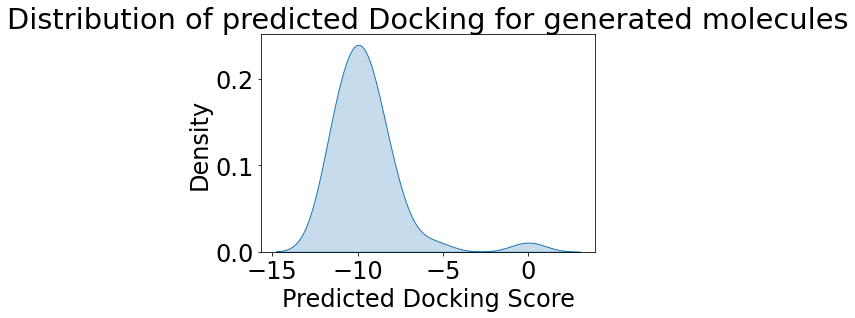

In [31]:
smiles, predictions = estimate_and_update(model, predictor, NUM_TO_GENERATE, kwargs['receptor'])

In [36]:
def get_all_props(smiles, predictions):
    mols = [Chem.MolFromSmiles(sm) for sm in smiles]
    LogPs = [Crippen.MolLogP(mol) for mol in mols]
    solv_predictor = FreeSolvPredictor('../Optimizer/Predictors/SolvationPredictor.tar')
    _, hydrations, _ = solv_predictor.predict(smiles, use_tqdm=False)
    tpsas = [CalcTPSA(mol) for mol in mols]
    qeds = []
    for mol in mols:
        try:
            qeds.append(qed(mol))
        except:
            pass
    return pd.DataFrame({
        'Smile': smiles,
        'Binding Affinity': predictions,
        'LogP': LogPs,
        'QED': qeds,
        'TPSA': tpsas,
        '$\Delta G_{Hyd}$': hydrations
    })

In [37]:
df = get_all_props(smiles, predictions)
df

,Smile,Binding Affinity,LogP,QED,TPSA,$\Delta G_{Hyd}$
0,C#Cc1ccccc1NCCNCc1ccccc1N1C(=O)c2ccccc2C1=O,-9.45,3.67020,0.364069,61.44,-9.673732
1,CC(=O)NCC(NC(=O)CC(Cc1csnn1)C(=O)N1CCCC(C)CC1)...,-11.60,2.92290,0.223014,162.49,-9.489832
2,CC(=O)Nc1ccc(C2=NC(=O)c3ccc(C4(C(=O)C5CCCN5C(=...,-11.00,4.45770,0.417799,119.97,-9.175395
3,CC(C(=O)OCCC1(O)Cc2ccccc2C1c1ccccc1)C1CCCC(NC(...,-10.49,6.69990,0.121912,130.08,-9.548204
4,CC(C)=CCC=C(C)CCCC1OC(=O)C(c2ccccc2)C1=O,-8.26,4.73760,0.412884,43.37,-4.208120
5,CC(C)N(CC(=O)NC(Cc1ccccc1)C(=O)COC(=O)c1ccccc1...,-7.75,4.56250,0.124884,168.05,-8.456795
6,CC(C)c1ccccc1-c1ccccc1CSC(=O)NCCc1ccc(CC(CC2CC...,-11.60,12.08380,0.107744,58.64,-4.757145
7,CC(Cc1ccc(C(=O)Nc2cnccn2)cc1)(CN1CCN(C(=O)c2cc...,-10.58,4.38110,0.129931,196.33,-10.075473
8,CC(Cc1ccccc1)Nc1ncnc2cc(F)ccc12,-8.00,3.81200,0.789849,37.81,-7.041093
9,CC1(C2=C(C(=O)O)C(=O)C(=NC(=O)c3ccccc3F)N2)CC1...,-9.39,3.71360,0.276221,159.07,-10.328918


## Binding Affinity

<AxesSubplot:xlabel='Binding Affinity', ylabel='Density'>

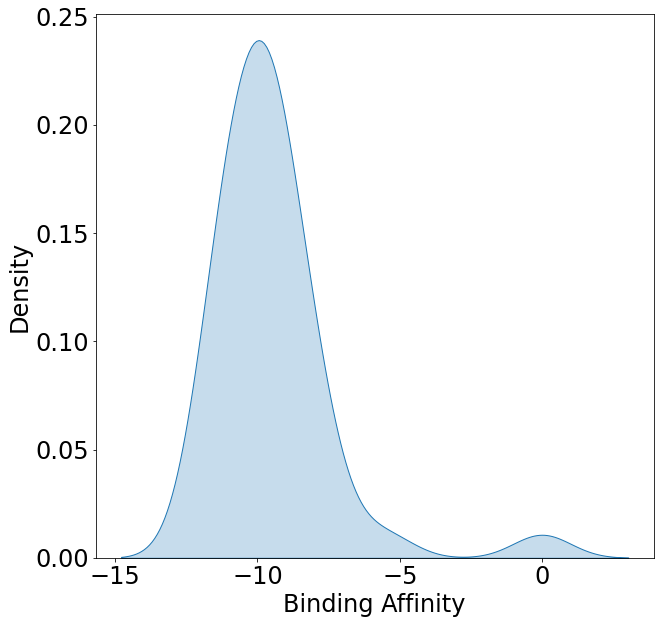

In [44]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})
sns.kdeplot(df['Binding Affinity'], shade=True)

## LogP

<AxesSubplot:xlabel='LogP', ylabel='Density'>

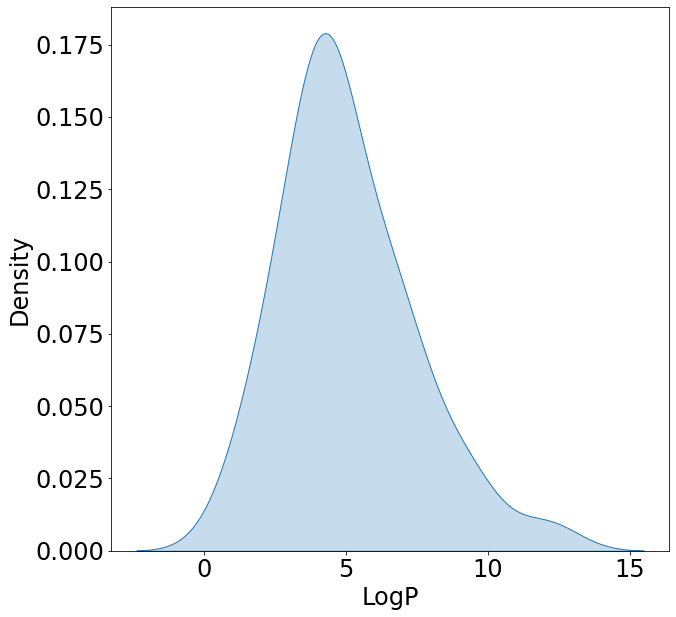

In [45]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})
sns.kdeplot(df['LogP'], shade=True)

## QED

<AxesSubplot:xlabel='QED', ylabel='Density'>

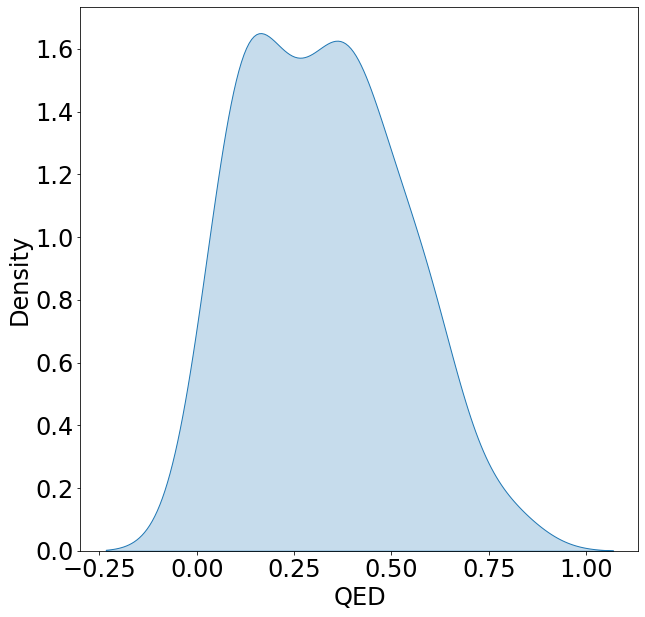

In [46]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})
sns.kdeplot(df['QED'], shade=True)

## TPSA

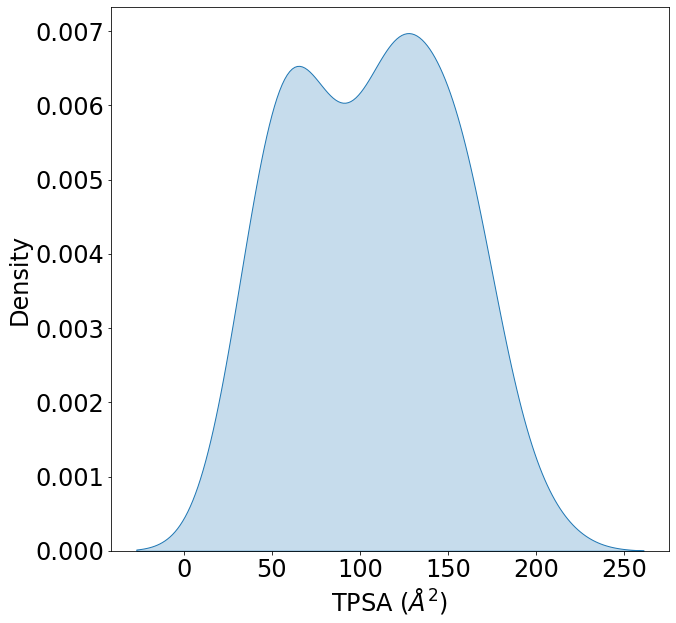

In [49]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})
sns.kdeplot(df['TPSA'], shade=True)
plt.xlabel('TPSA ($\AA^{2}$)')
plt.show()

## $\Delta G_{Hyd}$

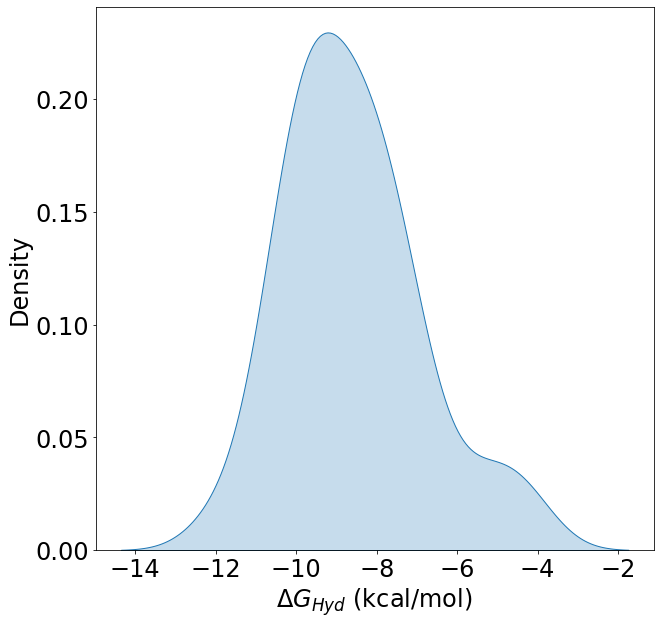

In [52]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})
sns.kdeplot(df['$\\Delta G_{Hyd}$'], shade=True)
plt.xlabel('$\\Delta G_{Hyd}$ (kcal/mol)')
plt.show()